Preprocess the data that comes directly from the Scan

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import medfilt

In [104]:
road_profile_num = 2

# Load the data
df_left1 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_left1.csv')
df_right1 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_right1.csv')
df_left2 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_left2.csv')
df_right2 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_right2.csv')
df_left3 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_left3.csv')
df_right3 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_right3.csv')
df_left4 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_left4.csv')
df_right4 = pd.read_csv(f'../../raw_data/road_profile{road_profile_num}/data_right4.csv')

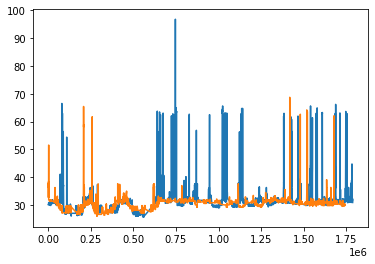

In [105]:

last_timestamp_left1 = df_left1['timestamp'].iloc[-1]
df_left2['timestamp'] = df_left2['timestamp'] + last_timestamp_left1
last_timestamp_left2 = df_left2['timestamp'].iloc[-1]
df_left3['timestamp'] = df_left3['timestamp'] + last_timestamp_left2
last_timestamp_left3 = df_left3['timestamp'].iloc[-1]
df_left4['timestamp'] = df_left4['timestamp'] + last_timestamp_left3

df_left = pd.concat([df_left1, df_left2, df_left3, df_left4])

last_timestamp_right1 = df_right1['timestamp'].iloc[-1]
df_right2['timestamp'] = df_right2['timestamp'] + last_timestamp_right1
last_timestamp_right2 = df_right2['timestamp'].iloc[-1]
df_right3['timestamp'] = df_right3['timestamp'] + last_timestamp_right2
last_timestamp_right3 = df_right3['timestamp'].iloc[-1]
df_right4['timestamp'] = df_right4['timestamp'] + last_timestamp_right3

df_right = pd.concat([df_right1, df_right2, df_right3, df_right4])

# Ensure 'distance' column is of string type before replacing
df_left['distance'] = df_left['distance'].astype(str).str.replace(' cm', '').astype(float)
df_right['distance'] = df_right['distance'].astype(str).str.replace(' cm', '').astype(float)

plt.plot(df_left['timestamp'], df_left['distance'], label='Left Sensor')
plt.plot(df_right['timestamp'], df_right['distance'], label='Right Sensor')
plt.show()



31.413621708413615

30.452702060730562

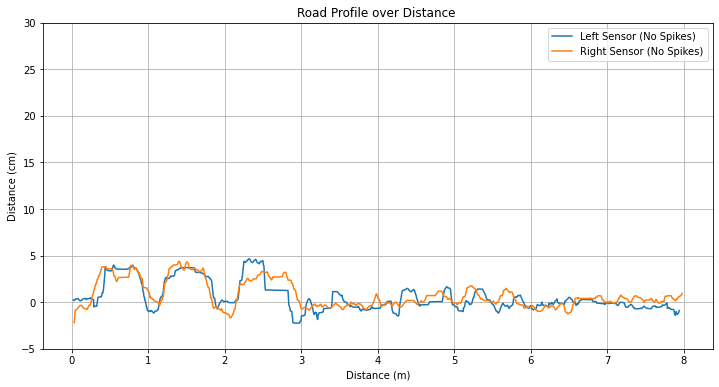

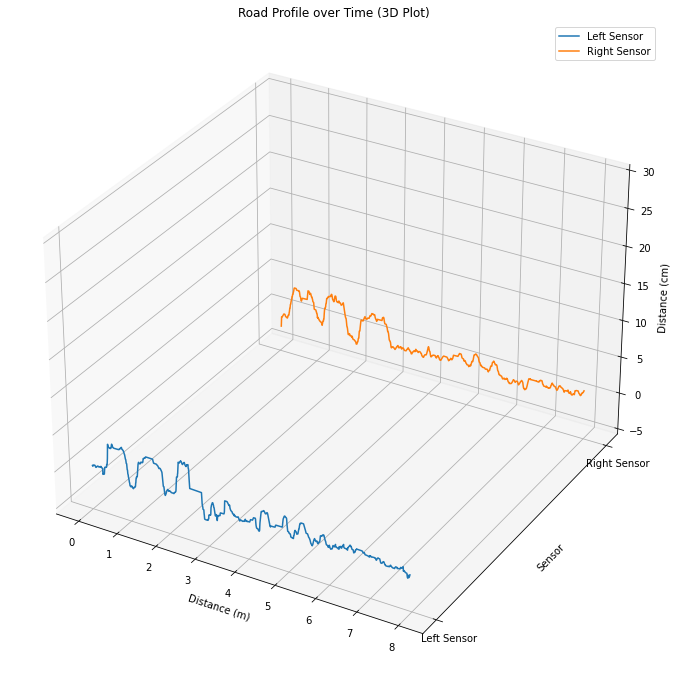

In [106]:

# Get Timestamp Alignment
prev_timestamp_difference = 1000000000
if df_left['timestamp'].iloc[0] < df_right['timestamp'].iloc[0]:
    goal_timestamp = df_right['timestamp'].iloc[0]
    for i in range(len(df_left['timestamp'])):
        timestamp_difference = abs(df_left['timestamp'].iloc[i] - goal_timestamp)
        if timestamp_difference < prev_timestamp_difference:
            prev_timestamp_difference = timestamp_difference
            timestamp_index = i
        else:
            df_left = df_left.iloc[timestamp_index:]
            break
else:
    goal_timestamp = df_left['timestamp'].iloc[0]
    for i in range(len(df_right['timestamp'])):
        timestamp_difference = abs(df_right['timestamp'].iloc[i] - goal_timestamp)
        if timestamp_difference < prev_timestamp_difference:
            prev_timestamp_difference = timestamp_difference
            timestamp_index = i
        else:
            df_right = df_right.iloc[timestamp_index:]
            break

# Interpolate missing values
df_left['distance'] = df_left['distance'].interpolate()
df_right['distance'] = df_right['distance'].interpolate()


# Entferne den Offset, indem du den Mittelwert abziehst und multipliziere mit -1
display(df_left['distance'].mean())
display(df_right['distance'].mean())

df_left['distance'] = (df_left['distance'] - 31) * -1
df_right['distance'] = (df_right['distance'] - 31) * -1

# Apply moving average filter
window_size = 50  # Window size for moving average filter
df_left['filtered_distance'] = df_left['distance'].rolling(window=window_size, center=True).mean()
df_right['filtered_distance'] = df_right['distance'].rolling(window=window_size, center=True).mean()

# Calculate the absolute difference between the original and filtered signals
df_left['spikes'] = abs(df_left['distance'] - df_left['filtered_distance'])
df_right['spikes'] = abs(df_right['distance'] - df_right['filtered_distance'])

# Identify spikes using a threshold
threshold = 0.5  # Define a threshold for spike detection
df_left.loc[df_left['spikes'] > threshold, 'distance'] = None
df_right.loc[df_right['spikes'] > threshold, 'distance'] = None

# Filter out values in 'distance' column that are over 20
additional_threshold = 30  # Define a threshold for high values
df_left = df_left[abs(df_left['distance']) <= additional_threshold]
df_right = df_right[abs(df_right['distance']) <= additional_threshold]

# Interpolate to remove spikes
df_left['distance'] = df_left['distance'].interpolate()
df_right['distance'] = df_right['distance'].interpolate()

# Apply Moving Average Filter
df_left['distance'] = df_left['distance'].rolling(window=100, center=True).mean()
df_right['distance'] = df_right['distance'].rolling(window=100, center=True).mean()

# Normalize timestamps to a distance scale (0m to 2m)
df_left['distance_scale'] = (df_left['timestamp'] - df_left['timestamp'].min()) / (df_left['timestamp'].max() - df_left['timestamp'].min()) * 8
df_right['distance_scale'] = (df_right['timestamp'] - df_right['timestamp'].min()) / (df_right['timestamp'].max() - df_right['timestamp'].min()) * 8

# Plotting the filtered data without spikes
plt.figure(figsize=(12, 6))
plt.plot(df_left['distance_scale'], df_left['distance'], label='Left Sensor (No Spikes)')
plt.plot(df_right['distance_scale'], df_right['distance'], label='Right Sensor (No Spikes)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (cm)')
plt.ylim(-5, 30)
plt.title('Road Profile over Distance ')
plt.legend()
plt.grid()

plt.savefig(f'../../processed_data/road_profile{road_profile_num}/2d_plot.jpg', format='jpg', dpi=300)
plt.show()

# Create a 3D plot without spikes
fig = plt.figure(figsize=(21, 12))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
ax.plot(df_left['distance_scale'], df_left['distance'], zs=0, zdir='y', label='Left Sensor')
ax.plot(df_right['distance_scale'], df_right['distance'], zs=1, zdir='y', label='Right Sensor')

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Sensor')
ax.set_zlabel('Distance (cm)')
ax.set_yticks([0, 1])
ax.set_zlim(-5, 30)
ax.set_yticklabels(['Left Sensor', 'Right Sensor'])
ax.set_title('Road Profile over Time (3D Plot)')
ax.legend()

plt.savefig(f'../../processed_data/road_profile{road_profile_num}/3d_plot.jpg', format='jpg', dpi=300)
plt.show()

In [107]:
df_left.to_csv(f'../../processed_data/road_profile{road_profile_num}/df_left_processed.csv', index=False)
df_right.to_csv(f'../../processed_data/road_profile{road_profile_num}/df_right_processed.csv', index=False)